In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm

In [3]:
from torch.optim import AdamW

In [4]:
# Check for GPU/TPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/jigsaw-toxic-comment-train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')
valid = pd.read_csv('/content/drive/MyDrive/Dataset/validation.csv')

In [6]:
# Tokenizer configuration
MAX_LEN = 192
BATCH_SIZE = 16
EPOCHS = 3
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [7]:
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, targets=None, tokenizer=None, max_len=512):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        inputs = {key: val.squeeze(0) for key, val in encoding.items()}
        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.float)
            return inputs, target
        return inputs


In [8]:
# Prepare datasets
train_dataset = ToxicCommentDataset(
    texts=train['comment_text'].astype(str).tolist(),
    targets=train['toxic'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

valid_dataset = ToxicCommentDataset(
    texts=valid['comment_text'].astype(str).tolist(),
    targets=valid['toxic'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = ToxicCommentDataset(
    texts=test['content'].astype(str).tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [9]:
class ToxicCommentModel(torch.nn.Module):
    def __init__(self):
        super(ToxicCommentModel, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [10]:
model = ToxicCommentModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [11]:
# Training function
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc='Training'):
        inputs, targets = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(1)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [12]:
# Validation function
def eval_fn(loader, model, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc='Validating'):
            inputs, targets = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            targets = targets.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(1)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

In [13]:
# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, device)
    valid_loss = eval_fn(valid_loader, model, loss_fn, device)
    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

Epoch 1/3


Validating: 100%|██████████| 500/500 [00:49<00:00, 10.00it/s]


Train Loss: 0.1148 | Valid Loss: 0.4651
Epoch 2/3


Validating: 100%|██████████| 500/500 [00:48<00:00, 10.23it/s]


Train Loss: 0.0854 | Valid Loss: 0.7475
Epoch 3/3


Validating: 100%|██████████| 500/500 [00:48<00:00, 10.27it/s]

Train Loss: 0.0639 | Valid Loss: 0.7740


In [15]:
import pickle

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save model weights
torch.save(model.state_dict(), "toxicity_model.pt")


In [17]:
import matplotlib.pyplot as plt

# Initialize lists to store losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, device)
    valid_loss = eval_fn(valid_loader, model, loss_fn, device)

Epoch 1/3


Training:   1%|          | 126/13972 [00:38<1:10:27,  3.28it/s]


KeyboardInterrupt: 

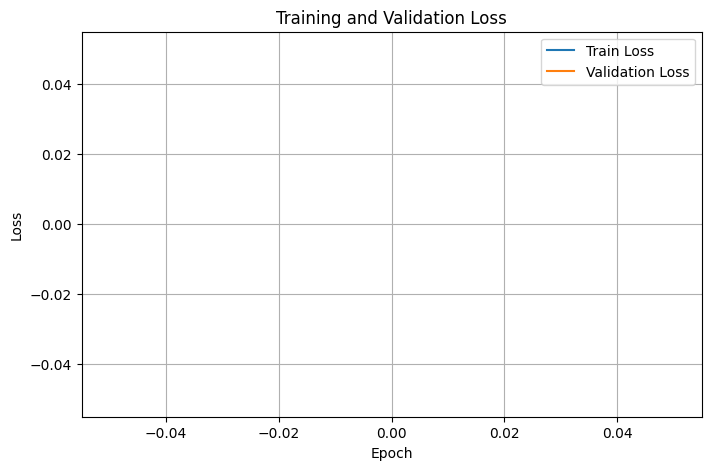

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


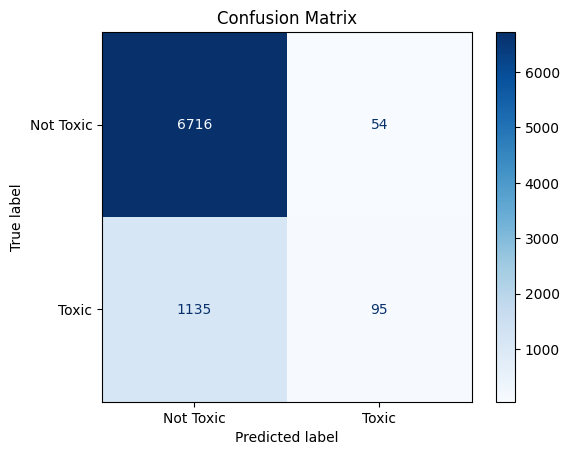

Classification Report:
              precision    recall  f1-score   support

   Not Toxic       0.86      0.99      0.92      6770
       Toxic       0.64      0.08      0.14      1230

    accuracy                           0.85      8000
   macro avg       0.75      0.53      0.53      8000
weighted avg       0.82      0.85      0.80      8000



In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def get_predictions(loader, model, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in loader:
            inputs, targets = batch
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs).squeeze(1).cpu().numpy()
            predictions.extend(probs)
            actuals.extend(targets.numpy())

    return np.array(predictions), np.array(actuals)

# Get predictions on validation set
preds, targets = get_predictions(valid_loader, model, device)
binary_preds = (preds >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(targets, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Toxic', 'Toxic'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(targets, binary_preds, target_names=['Not Toxic', 'Toxic']))
